In [1]:
# installing tensorflow_text 
!pip install tensorflow_text  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
# importing required libraries
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
# using builtin implementations
use_builtins = True

In [4]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [5]:
!pip install Metaphone
from metaphone import doublemetaphone
import pandas as pd
import re

  Preparing metadata (setup.py) ... done
  Created wheel for Metaphone: filename=Metaphone-0.6-py3-none-any.whl size=13919 sha256=8cbe16aab756ac513cce1b9ae66f39189df1b7e4a58f9ee6b083206b436a44c0
  Stored in directory: /root/.cache/pip/wheels/3a/2c/57/cb7d38aa6c80a870a0341ccf4265c2921fb55b1f7f4b76b46b
Successfully built Metaphone


In [6]:
data1=pd.read_csv("/kaggle/input/google-reasearch/train.tsv",sep='\t')
data1

,en_query,cs_query,en_parses,cs_parses
0,Who is the featured performer at The Grand Ole...,Is Saturday night The Grand Ole Opry me featur...,[IN:GET_EVENT Who is [SL:CATEGORY_EVENT the fe...,[IN:GET_EVENT [SL:DATE_TIME Is Saturday night ...
1,Remind me of my meeting at 12 am,mujhe 12 am ko meri meeting ke baare me yaad d...,[IN:CREATE_REMINDER Remind [SL:PERSON_REMINDED...,[IN:CREATE_REMINDER [SL:PERSON_REMINDED mujhe ...
2,set an alarm for 5 am,subha 5 baje ke liye ek alarm set karen,[IN:CREATE_ALARM set an alarm [SL:DATE_TIME fo...,[IN:CREATE_ALARM [SL:DATE_TIME subha 5 baje ke...
3,What ’ s will weather be like at Sydney at 2 pm,dopaher 2 baje Sydney me mausam kaisa hoga,[IN:GET_WEATHER What ’s will weather be like a...,[IN:GET_WEATHER [SL:DATE_TIME dopaher 2 baje ]...
4,What is the weather in Canada ?,Canada me mausam kaisa hai ?,[IN:GET_WEATHER What is the weather in [SL:LOC...,[IN:GET_WEATHER [SL:LOCATION Canada ] me mausa...
...,...,...,...,...
170078,How many miles from Humble to Brenham,Humble se Brenham tak kitne miles hai,[IN:GET_DISTANCE How many [SL:UNIT_DISTANCE mi...,[IN:GET_DISTANCE [SL:SOURCE Humble ] se [SL:DE...
170079,What is traffic so bad on Ronald Reagan,Ronald Reagan par traffic kyu kharaab hai,[IN:GET_INFO_TRAFFIC What is traffic so bad on...,[IN:GET_INFO_TRAFFIC [SL:LOCATION Ronald Reaga...
170080,Concerts by The Strokes for this weekend,Is weekend The Strokes ke hone wale Concerts,[IN:GET_EVENT [SL:CATEGORY_EVENT Concerts ] by...,[IN:GET_EVENT [SL:DATE_TIME Is weekend ] [SL:N...
170081,How many mm of rain do we expect for tomorrow ?,kal kitni mm baarish ki ummeed hai ?,[IN:UNSUPPORTED_WEATHER How many mm of [SL:WEA...,[IN:UNSUPPORTED_WEATHER kal kitni mm [SL:WEATH...


In [7]:
data1['en_query']=data1['en_query'].apply(lambda x: str(x.strip()).lower())
data1['cs_query']=data1['cs_query'].apply(lambda x: str(x.strip()).lower())

In [8]:
data1=data1[['cs_query','en_query']]
data1.rename(columns = {'cs_query':'Sentence','en_query':'trr'},inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
data1

,Sentence,trr
0,is saturday night the grand ole opry me featur...,who is the featured performer at the grand ole...
1,mujhe 12 am ko meri meeting ke baare me yaad d...,remind me of my meeting at 12 am
2,subha 5 baje ke liye ek alarm set karen,set an alarm for 5 am
3,dopaher 2 baje sydney me mausam kaisa hoga,what ’ s will weather be like at sydney at 2 pm
4,canada me mausam kaisa hai ?,what is the weather in canada ?
...,...,...
170078,humble se brenham tak kitne miles hai,how many miles from humble to brenham
170079,ronald reagan par traffic kyu kharaab hai,what is traffic so bad on ronald reagan
170080,is weekend the strokes ke hone wale concerts,concerts by the strokes for this weekend
170081,kal kitni mm baarish ki ummeed hai ?,how many mm of rain do we expect for tomorrow ?


In [10]:
data=pd.read_csv("/kaggle/input/file-2/file2.csv")
data

,Sentence,English_Translation,trr,tr
0,congratulations on you celebrating british kid...,users congratulate you for celebrating British...,congratulations on you celebrating british kid...,congratulations on you celebrating british kid...
1,uske liye toh bahot kuch karna padega ye pappi...,"rat we should a lot more for that, by this evi...","you will have to do a lot for that, it will no...","you will have to do a lot for that, it will no..."
2,yehi to hum semjhane ki koshish kar rahe hain....,"ehi, this is what i'm expecting you to underst...",this is what we are trying to understand. peop...,this is what we are trying to understand. peop...
3,cake kaha hai ??,is Dramebajakudi where is the cake?,where is the cake??,where is the cake??
4,jeet ka jashn aur shubah ki shuruat eating bre...,the celebration of a victory and the start of ...,victory celebration and early morning eating b...,victory celebration and early morning eating b...
...,...,...,...,...
12143,"dr kumar vishwas: ""koi deewana kehta hai.. koi...","Dr Kumar Vishwas: ""Some used to say lover.. So...","dr. kumar vishwas: ""some say crazy..some think...","dr. kumar vishwas: ""some say crazy..some think..."
12144,me: aaj kuch toofani karte hai.mom: pani ki bo...,Me: Let's do some stormy today.Mom: Fill the w...,me: let's do something stormy today. mother: f...,me: let's do something stormy today. mother: f...
12145,"pyar mangi to jaan dengi,milk mango to kher de...","Ask for love we'll give life, ask for milk we'...","if you ask for love, you will give your life, ...","if you ask for love, you will give your life, ..."
12146,kaale kaale baal gaal gore gore,black hair cheeks fair fair,kale kale bal gal gore gore,kale kale bal gal gore gore


In [11]:
data=data[['Sentence','trr']]
data

,Sentence,trr
0,congratulations on you celebrating british kid...,congratulations on you celebrating british kid...
1,uske liye toh bahot kuch karna padega ye pappi...,"you will have to do a lot for that, it will no..."
2,yehi to hum semjhane ki koshish kar rahe hain....,this is what we are trying to understand. peop...
3,cake kaha hai ??,where is the cake??
4,jeet ka jashn aur shubah ki shuruat eating bre...,victory celebration and early morning eating b...
...,...,...
12143,"dr kumar vishwas: ""koi deewana kehta hai.. koi...","dr. kumar vishwas: ""some say crazy..some think..."
12144,me: aaj kuch toofani karte hai.mom: pani ki bo...,me: let's do something stormy today. mother: f...
12145,"pyar mangi to jaan dengi,milk mango to kher de...","if you ask for love, you will give your life, ..."
12146,kaale kaale baal gaal gore gore,kale kale bal gal gore gore


In [12]:
df=pd.concat([data,data1],axis=0)
df

,Sentence,trr
0,congratulations on you celebrating british kid...,congratulations on you celebrating british kid...
1,uske liye toh bahot kuch karna padega ye pappi...,"you will have to do a lot for that, it will no..."
2,yehi to hum semjhane ki koshish kar rahe hain....,this is what we are trying to understand. peop...
3,cake kaha hai ??,where is the cake??
4,jeet ka jashn aur shubah ki shuruat eating bre...,victory celebration and early morning eating b...
...,...,...
170078,humble se brenham tak kitne miles hai,how many miles from humble to brenham
170079,ronald reagan par traffic kyu kharaab hai,what is traffic so bad on ronald reagan
170080,is weekend the strokes ke hone wale concerts,concerts by the strokes for this weekend
170081,kal kitni mm baarish ki ummeed hai ?,how many mm of rain do we expect for tomorrow ?


In [13]:
hin_vocab=dict()
for i in df['Sentence'].apply(lambda x: re.sub("[.!?\\-\'\"]", "", x)):
    for j in i.split(' '):
        hin_vocab[doublemetaphone(j)[0]+'*'+doublemetaphone(j[::-1])[0]+'*'+j[:2]+'*'+j[len(j)-1:]]=j
for i in hin_vocab:
    a=set()
    a.add(hin_vocab[i])
    hin_vocab[i]=a
for i in df['Sentence'].apply(lambda x: re.sub("[.!?\\-\'\"]", "", x)):
    for j in i.split(' '):
        hin_vocab[doublemetaphone(j)[0]+'*'+doublemetaphone(j[::-1])[0]+'*'+j[:2]+'*'+j[len(j)-1:]].add(j)
print(len(hin_vocab))
hin_vocab

26214


{'KNKRTLXNS*SNTLTRNK*co*s': {'congratulations'},
 'AN*N*on*n': {'on'},
 'A*A*yo*u': {'you', 'youuuuu', 'youuuuuu'},
 'SLPRTNK*NTRPLK*ce*g': {'celebrating'},
 'PRTX*STRP*br*h': {'british'},
 'KT*TK*ki*d': {'kid', 'kidd'},
 'SNKRS*SRNS*si*s': {'singers'},
 'SF*APS*so*a': {'sophia'},
 'KRSS*SKRK*gr*s': {'graces', 'grocess'},
 'ANT*TN*an*d': {'and'},
 'RSS*SSR*ro*s': {'roses', 'rosies'},
 'ST*TS*st*t': {'st'},
 'ANFRSR*ARSRFN*an*y': {'anniversary'},
 'AF*F*of*f': {'of', 'off'},
 'A*A*a*a': {'a'},
 'FST*TSF*vi*t': {'visit', 'vist'},
 'AR*R*yo*r': {'yor', 'your'},
 'X*AS*sh*w': {'shaw', 'show'},
 '***': {''},
 'H*A*ho*w': {'how'},
 'ASK*AKS*us*e': {'uske'},
 'L*AL*li*e': {'lie', 'liye', 'liyee', 'liyeee', 'liyye'},
 'T*HT*to*h': {'toh'},
 'PHT*THP*ba*t': {'bahaut', 'bahot', 'bahuat', 'bahut'},
 'KX*KK*ku*h': {'kucch', 'kucchh', 'kuch'},
 'KRN*ANRK*ka*a': {'karana', 'kareena', 'karna', 'karwana'},
 'PTK*AJTP*pa*a': {'padega', 'padhega', 'padhiyega'},
 'A*A*ye*e': {'ye', 'yee', 'yeeeeee'},
 'P

In [14]:
df['Sentence']=df['Sentence'].apply(lambda x: re.sub("[.!?\\-\'\"]", "", x))
df['Sentence']

0         congratulations on you celebrating british kid...
1         uske liye toh bahot kuch karna padega ye pappi...
2         yehi to hum semjhane ki koshish kar rahe hain ...
3                                            cake kaha hai 
4         jeet ka jashn aur shubah ki shuruat eating bre...
                                ...                        
170078                humble se brenham tak kitne miles hai
170079            ronald reagan par traffic kyu kharaab hai
170080         is weekend the strokes ke hone wale concerts
170081                  kal kitni mm baarish ki ummeed hai 
170082                              sarey alarms cance kare
Name: Sentence, Length: 182231, dtype: object

In [15]:
def change_vocab(line):
    string=''
    for j in line.split(' '):
        string=string+list(hin_vocab[doublemetaphone(j)[0]+'*'+doublemetaphone(j[::-1])[0]+'*'+j[:2]+'*'+j[len(j)-1:]])[0]+' '
    return string

In [16]:
change_vocab('sarey alarms cance kare')

'saray alarms cance karre '

In [18]:
df['Sentence']=df['Sentence'].apply(lambda x: change_vocab(x).strip())

In [19]:
df

,Sentence,trr
0,congratulations on youuuuuu celebrating britis...,congratulations on you celebrating british kid...
1,uske liyee toh bahut kucch karwana padega yeee...,"you will have to do a lot for that, it will no..."
2,yehi to hum semjhane kii koshishh karr rahe ha...,this is what we are trying to understand. peop...
3,cake kaha hawaii,where is the cake??
4,jet kaa jashn aur shubah kii shohrat eating br...,victory celebration and early morning eating b...
...,...,...
170078,humble see brenham tak kitne miles hawaii,how many miles from humble to brenham
170079,ronald reagan pawar trafic kyu kharab hawaii,what is traffic so bad on ronald reagan
170080,is wekeend thhe strikes ke hone wale concerts,concerts by the strokes for this weekend
170081,kael kidni mm barish kii umeed hawaii,how many mm of rain do we expect for tomorrow ?


In [20]:
df = df.sample(frac = 1)

In [21]:
df['len_sen']=df['Sentence'].apply(lambda x: len(x.split(' ')))
df=df[df['len_sen']<=20]

In [22]:
inp=list(df['Sentence'])
targ=list(df['trr'])

In [23]:
# printing last english sentence
print(targ[-1])

set alarm for every 5 minutes


In [24]:
!nvidia-smi

Tue Mar 14 12:07:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [26]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17557909440861548298
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16105865216
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3339049691903498145
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [27]:
tf.test.is_gpu_available()

True

In [28]:
# printing first 100 english sentence
print(targ[:100])

['cancel timer and reset for twenty minutes .', "i want to listen to linkin park ' s last album", 'change to alt rock .', 'snooze alarm for 10 minutes', 'this timer needs to be changed to 10 minutes', 'remove my reminder to get sandwich lunch meat tomorrow', 'the one who messes with didi, disappears.. india had also messed with didi.', 'what are the current events in washington dc', 'are the roads icy on route 10 right now', 'should i dress in layers', 'does it make more sense for me to take the freeway home or to take an uber', 'start the album at the beginning', 'what is the weather like near santa monica right now', 'what are the conditions of traffic in phoenix right now', "i need a reminder for my daughter ' s piano lesson today at 4 : 30 .", 'please provide alternative routes to my ob - gyn clinic address .', 'put on repeat', 'shuffle my music .', "what ' s the traffic today", 'pause the track', 'set up a reminder to buy milk and bread on my way home from work today .', 'remind m

In [29]:
# printing first 100 hinglish sentences
print(inp[-1:])

['harr 5 minutes ke liyee alaram seet karre']


In [30]:
# arrays of strings are shuffled and batches are made
BUFFER_SIZE = len(inp)
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [31]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'1 hour ke liyee timer seet karre'
 b'yeeeeee royal haaye, tikdi alag thei'
 b'is wekeend cranbury mee concerts'
 b'subha 5 bajaye ke liyee repeating alaram seet karein'
 b'please japanese mee music bheje'], shape=(5,), dtype=string)

tf.Tensor(
[b'set a timer for 1 hour .' b'this is the role, the trio was different'
 b'concerts in cranberry this weekend' b'set a repeating alarm for 5 am'
 b'rap music in japanese , please'], shape=(5,), dtype=string)


In [32]:
# unicode normalization operation - first step to standardize data
example_text = tf.constant('Yahi haal hai')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Yahi haal hai'
b'Yahi haal hai'


In [33]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [34]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Yahi haal hai
[START] yahi haal hai [END]


In [35]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(    # handles vocabulary extraction & conversion of i/p text to sequences of tokens
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [36]:
input_text_processor.adapt(inp)    # initializes the layer based on the data

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]
# Hinglish TextVectorization layer

['', '[UNK]', '[START]', '[END]', 'ke', 'liyee', 'hawaii', 'ko', 'kyaa', 'mee']

In [37]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]
# English TextVectorization layer

['', '[UNK]', '[START]', '[END]', 'the', 'to', '.', 'for', 'is', '?']

In [38]:
# the above layers convert a batch of strings into a batch of token IDs
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,  273,    4,    5,   19,   14,   10,    3,    0,    0],
       [   2,  121, 1570,  470,   40,    1, 2552,  639,    3,    0],
       [   2,   23,   53,    1,    9,  171,    3,    0,    0,    0]])>

In [39]:
# get_vocabulary - converts token IDs back to text
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] hour ke liyee timer seet karre [END]            '

Text(0.5, 1.0, 'Mask')

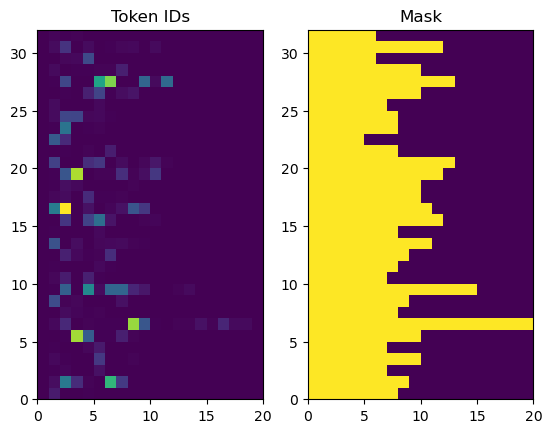

In [40]:
# token IDs converted into a mask
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [41]:
# defining constants for the model
embedding_dim = 256
units = 1024

Encoding

In [42]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                  recurrent_dropout=0.15)

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [43]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (32,)
Input batch tokens, shape (batch, s): (32, 20)
Encoder output, shape (batch, s, units): (32, 20, 1024)
Encoder state, shape (batch, units): (32, 1024)


Attention layer

In [44]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [45]:
# creating BahdanauAttention layer
attention_layer = BahdanauAttention(units)

In [46]:
(example_tokens != 0).shape

TensorShape([32, 20])

In [47]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (32, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (32, 2, 20)


Text(0.5, 1.0, 'Mask')

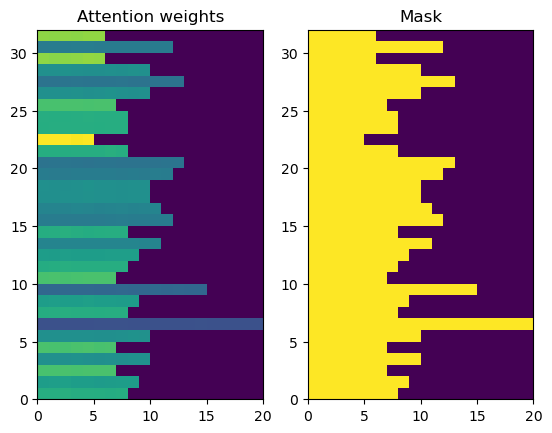

In [48]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


In [49]:
attention_weights.shape

TensorShape([32, 2, 20])

In [50]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 640x480 with 0 Axes>

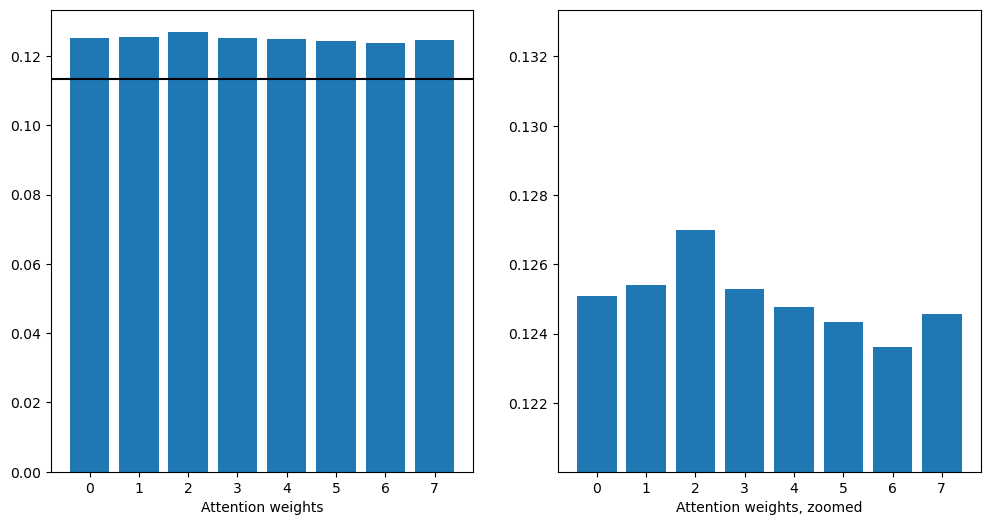

In [51]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

Decoder

In [52]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                  recurrent_dropout=0.15)

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [53]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [54]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [55]:
Decoder.call = call

In [56]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [57]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [58]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (32, 1, 5000)
state shape: (batch_size, dec_units) (32, 1024)


In [59]:
# sample token according to logits
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [60]:
# decode the token as first word of o/p
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['annie'],
       ['markets'],
       ['creat'],
       ['ringing'],
       ['wear']], dtype='<U15')

In [61]:
# decoder generates second set of logits
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [62]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['via'],
       ['player'],
       ['delays'],
       ['pike'],
       ['floor']], dtype='<U15')

Training

In [63]:
# Loss function definition
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [64]:
# implementing training step
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [65]:
# Receiving batches of english & hinglish data
# Converting those raw text inputs to token-embeddings and masks.
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [66]:
TrainTranslator._preprocess = _preprocess

In [67]:
# training
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [68]:
TrainTranslator._train_step = _train_step

In [69]:
# executes the decoder and calculates the incremental loss and new decoder state 
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [70]:
TrainTranslator._loop_step = _loop_step

In [71]:
# testing the training step
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [72]:
np.log(output_text_processor.vocabulary_size())

8.517193191416236

In [73]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.599195>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5705476>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.515734>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3451343>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.6364293>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.763548>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2912674>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9837527>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8288238>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.796238>}

CPU times: user 26.5 s, sys: 1.15 s, total: 27.6 s
Wall time: 26.8 s


In [74]:
# maximizing performance while training
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [75]:
TrainTranslator._tf_train_step = _tf_train_step

In [76]:
translator.use_tf_function = True

In [77]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7653503>}

In [78]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6711607>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5843291>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.464444>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4330518>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.403814>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.351172>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2842996>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.248757>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.204882>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.139815>}

CPU times: user 3.76 s, sys: 432 ms, total: 4.19 s
Wall time: 2.53 s


....................................................................................................


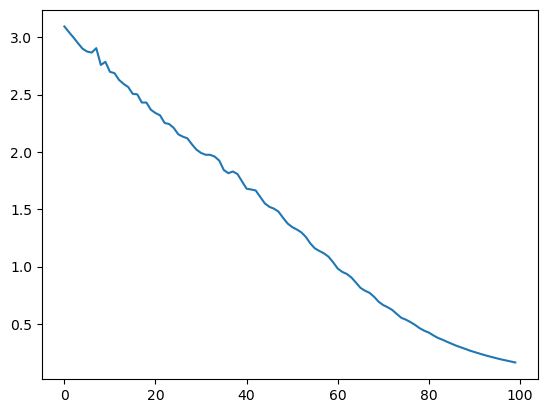

In [79]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [80]:
# building a fresh copy of the model to train from scratch since the training step is working
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Training the model

In [81]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [83]:
#train_translator.fit(dataset, epochs=15,
#                     callbacks=[batch_loss])

In [84]:
for c in range(5):
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 32
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)

5598/5598 [==============================] - 1531s 273ms/step - batch_loss: 0.5316


In [85]:
for c in range(1):
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 16
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)

5598/5598 [==============================] - 1518s 271ms/step - batch_loss: 0.4841


In [114]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 64
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

2799/2799 [==============================] - 854s 305ms/step - batch_loss: 0.3393


In [128]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 64
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

2799/2799 [==============================] - 849s 303ms/step - batch_loss: 0.2854


In [141]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 64
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

2799/2799 [==============================] - 845s 302ms/step - batch_loss: 0.2683


In [155]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 128
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

1400/1400 [==============================] - 504s 360ms/step - batch_loss: 0.1735


In [168]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 128
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

1400/1400 [==============================] - 489s 349ms/step - batch_loss: 0.1301


In [182]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 128
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

1400/1400 [==============================] - 493s 352ms/step - batch_loss: 0.1357


In [196]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 256
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

700/700 [==============================] - 338s 482ms/step - batch_loss: 0.0973


In [209]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 256
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

700/700 [==============================] - 324s 462ms/step - batch_loss: 0.0702


KeyboardInterrupt: 

In [222]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 512
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1,
                     callbacks=[batch_loss])

350/350 [==============================] - 268s 764ms/step - batch_loss: 0.0536


KeyboardInterrupt: 

In [236]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 1024
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1)

175/175 [==============================] - 239s 1s/step - batch_loss: 0.0409


KeyboardInterrupt: 

In [267]:
for c in range(1):
    df = df.sample(frac = 1)
    inp=list(df['Sentence'])
    targ=list(df['trr'])
    BUFFER_SIZE = len(inp)
    BATCH_SIZE = 2048
    dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    train_translator.fit(dataset, epochs=1)

ResourceExhaustedError: Graph execution error:

Detected at node 'while/decoder_2/bahdanau_attention_3/dense_11/Tensordot/MatMul' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_23/335468804.py", line 3, in <module>
      callbacks=[batch_loss])
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/tmp/ipykernel_23/3733470266.py", line 24, in train_step
      return self._tf_train_step(inputs)
    File "/tmp/ipykernel_23/626488378.py", line 5, in _tf_train_step
      return self._train_step(inputs)
    File "/tmp/ipykernel_23/4151822410.py", line 22, in _train_step
      for t in tf.range(max_target_length-1):
    File "/tmp/ipykernel_23/4151822410.py", line 27, in _train_step
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
    File "/tmp/ipykernel_23/431701214.py", line 10, in _loop_step
      dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_23/2024488487.py", line 24, in call
      context_vector, attention_weights = self.attention(
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_23/696840811.py", line 21, in call
      w2_key = self.W2(value)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/core/dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'while/decoder_2/bahdanau_attention_3/dense_11/Tensordot/MatMul'
Detected at node 'while/decoder_2/bahdanau_attention_3/dense_11/Tensordot/MatMul' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_23/335468804.py", line 3, in <module>
      callbacks=[batch_loss])
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/tmp/ipykernel_23/3733470266.py", line 24, in train_step
      return self._tf_train_step(inputs)
    File "/tmp/ipykernel_23/626488378.py", line 5, in _tf_train_step
      return self._train_step(inputs)
    File "/tmp/ipykernel_23/4151822410.py", line 22, in _train_step
      for t in tf.range(max_target_length-1):
    File "/tmp/ipykernel_23/4151822410.py", line 27, in _train_step
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
    File "/tmp/ipykernel_23/431701214.py", line 10, in _loop_step
      dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_23/2024488487.py", line 24, in call
      context_vector, attention_weights = self.attention(
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_23/696840811.py", line 21, in call
      w2_key = self.W2(value)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/layers/core/dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'while/decoder_2/bahdanau_attention_3/dense_11/Tensordot/MatMul'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[47104,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node while/decoder_2/bahdanau_attention_3/dense_11/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[StatefulPartitionedCall/while/loop_body_control/_609/_53]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[47104,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node while/decoder_2/bahdanau_attention_3/dense_11/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_257718]

Text(0, 0.5, 'CE/token')

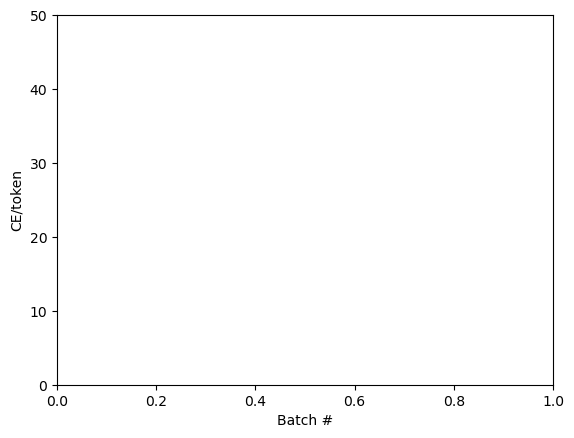

In [115]:
#### plt.plot(batch_loss.logs)
plt.ylim([0, 50])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

Translation

In [237]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [238]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [239]:
# converting token IDs to human readable text
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [240]:
Translator.tokens_to_text = tokens_to_text

In [241]:
# inputting random token IDs to see what it generates
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'tone maryland', b'teams hemet', b'furnace settings',
       b'lakers ridge', b'sally cab'], dtype=object)

In [242]:
# takes the decoder's logit outputs and samples token IDs from that distribution
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [243]:
Translator.sample = sample

In [244]:
# testing the function on random i/p
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[4926],
       [1147],
       [3418],
       [1995],
       [3190]])>

In [245]:
# implementing text to text translation loop
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [246]:
Translator.translate = translate_unrolled

In [247]:
change_vocab('tum kaise ho')

'tum kaise hooo '

In [249]:
# TESTING
input_text = tf.constant([
    change_vocab('kaha jana hai'),
    change_vocab('tumhare papa kya kaam karte hai '),
    change_vocab('tumhara papa ka naam kya hai'),
    change_vocab('maine khana kha liya hai')
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print(result['text'][2].numpy().decode())
print(result['text'][3].numpy().decode())
print()

where have you been
what do you do as your father ?
what is the name of your father ?
i ate food



In [250]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [251]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 20.1 s, sys: 160 ms, total: 20.2 s
Wall time: 20.3 s


In [252]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

where have you been
is your father done ? to do work ?

CPU times: user 117 ms, sys: 17.5 ms, total: 134 ms
Wall time: 98.7 ms


In [253]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [254]:
Translator.translate = translate_symbolic

The initial implementation used python lists to collect the outputs. This uses `tf.range` as the loop iterator, allowing `tf.autograph` to convert the loop. The biggest change in this implementation is the use of `tf.TensorArray` instead of python `list` to accumulate tensors. `tf.TensorArray` is required to collect a variable number of tensors in graph mode. 

With eager execution this implementation performs on par with the original:

In [255]:
# RUN THIS
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

where have you been
are your father ? what do you work ?



But when you wrap it in a `tf.function` you'll notice two differences.

In [256]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

First: Graph creation is much faster (~10x), since it doesn't create `max_iterations` copies of the model.

In [257]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.19 s, sys: 9.17 ms, total: 1.2 s
Wall time: 1.19 s


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.

In [258]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

where have you fallen
what do you do as your father ?

CPU times: user 43.6 ms, sys: 4.28 ms, total: 47.9 ms
Wall time: 34.2 ms


### Visualize the process

The attention weights returned by the `translate` method show where the model was "looking" when it generated each output token.

So the sum of the attention over the input should return all ones:

In [ ]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

Here is the attention distribution for the first output step of the first example. Note how the attention is now much more focused than it was for the untrained model:

In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

Since there is some rough alignment between the input and output words, you expect the attention to be focused near the diagonal:

In [ ]:
plt.imshow(np.array(a), vmin=0.0)

Here is some code to make a better attention plot:

In [ ]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [259]:
%%time
three_input_text = tf.constant([#'sabse best friend', 
                                #'That toh I know',
                                #change_vocab('She was bhunnoing the masalas jub phone ki ghuntee bugee'),
                                change_vocab('tum batao'),
                                change_vocab('kya karna hai'),
])

result = translator.tf_translate(three_input_text)
print(result['text'])
for tr in result['text']:
  print(tr.numpy().decode())

print()

tf.Tensor([b'you tell me' b'is there a way to do'], shape=(2,), dtype=string)
you tell me
is there a way to do

CPU times: user 43.5 ms, sys: 2.13 ms, total: 45.6 ms
Wall time: 47.6 ms


In [ ]:
result['text']

In [ ]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

In [ ]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('Graph')

In [260]:
tf.saved_model.save(translator, 'translator1',
                    signatures={'serving_default': translator.tf_translate})

In [261]:
!cd /kaggle/working

In [262]:
!ls

__notebook_source__.ipynb  translator1


In [263]:
!zip -r translator.zip translator1

  adding: translator1/ (stored 0%)
  adding: translator1/variables/ (stored 0%)
  adding: translator1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: translator1/variables/variables.index (deflated 57%)
  adding: translator1/assets/ (stored 0%)
  adding: translator1/fingerprint.pb (stored 0%)
  adding: translator1/saved_model.pb (deflated 81%)


In [264]:
from IPython.display import FileLink
FileLink(r'translator.zip')

/kaggle/working/translator.zip

In [ ]:
reloaded = tf.saved_model.load('translator1')
result = reloaded.tf_translate(three_input_text)

In [ ]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()